(0.0, 20.0)

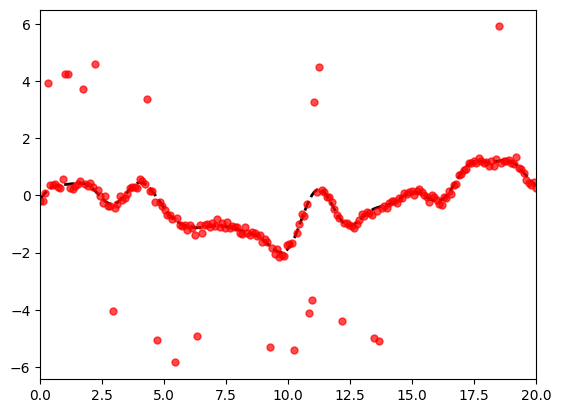

In [1]:
from typing import Optional

import tensorflow as tf
import numpy as np
from check_shapes import check_shapes, inherit_check_shapes
from typing import Optional, Tuple, Type, Union, cast
import tensorflow_probability as tfp
import gpflow

from gpflow.base import InputData, MeanAndVariance, RegressionData, TensorData
from gpflow.kernels import Kernel
from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import MeanFunction
from gpflow.models.model import GPModel
from gpflow.models.training_mixins import InternalDataTrainingLossMixin
from gpflow.models.util import data_input_to_tensor
from gpflow.config import default_float, default_jitter
from gpflow.utilities import to_default_float
from gpflow import posteriors
from gpflow.utilities.ops import eye
import random
import w 
import tensorflow as tf
import numpy as np
import gpflow

import matplotlib.pyplot as plt
tf.keras.config.set_floatx('float64')
seed = 10


#set seed
np.random.seed(seed)
tf.random.set_seed(seed)

#create X
n_points = 200
sigma_n = 0.1
#percentage of points in x which are biased
percent_miss=0.1


#
lengthscale = 1
variance = 1

variance_out = 2

kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)

i_obs = np.random.choice(
    np.arange(0, n_points, 1), int( n_points), replace=False)

y_obs = f[i_obs] + np.random.normal(scale=sigma_n, size=n_points).reshape(n_points, 1)
x_obs = x[i_obs]

arr1inds = x_obs[:,0].argsort()
x_obs = x_obs[arr1inds]
y_obs = y_obs[arr1inds]

i_mis = np.random.choice(
    np.arange(0, n_points, 1), int(percent_miss * n_points), replace=False)

y_mis_pos = y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]]  + np.random.uniform(3, 5, size=len(i_mis[(y_obs[i_mis]>0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]>0)[:,0]]),1)
y_mis_neg = y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]]  - np.random.uniform(3, 5, size=len(i_mis[(y_obs[i_mis]<=0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]<=0)[:,0]]),1)
y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]] = y_mis_pos
y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]] = y_mis_neg
X=x
y=y_obs

plt.plot(x, f, color='black', ls='--', lw=2)
plt.plot(x_obs, y_obs, 'r.', ms=10, alpha=0.7)
plt.xlim(x[0], x[-1])

In [67]:
    


@tf.function
def loo_cv(X, y, mean_function, kernel, W, noise_variance, likelihood) -> tf.Tensor:
    r"""
    Computes the leave one out to train the model
    """
    err = y - tf.reshape(mean_function(X), (-1, 1))
    K = kernel.matrix(X, X)
    n = tf.cast(tf.shape(X)[0], K.dtype)

    likelihood_variance = likelihood.variance_at(X)  #####WHAT IS THIS???
    W = IMQ(c)

    W, W_dy = W.w_dy(X, err)
    dylog2 = 2 * likelihood_variance * W_dy / W
    Y_bar = err - dylog2

    K_sW = add_noise_cov(K, tf.squeeze(W, axis=-1), tf.squeeze(likelihood_variance, axis=-1))
    L_sW = tf.linalg.cholesky(K_sW)
    L_sW_inv = tf.linalg.inv(L_sW)

    #K_sW_inv = tf.linalg.matmul(L_sW_inv, L_sW_inv, transpose_a=True)

    #diag_K_sW_inv = tf.reshape(tf.linalg.diag_pxart(K_sW_inv), (-1, 1))
    diag_K_sW_inv = tf.reshape(tf.reduce_sum(L_sW_inv ** 2, axis=0), (-1, 1))

    A = diag_K_sW_inv * dylog2

    #B = tf.matmul(K_sW_inv, Y_bar)
    B = tf.matmul(L_sW_inv, tf.matmul(L_sW_inv, Y_bar), transpose_a=True)
    C = diag_K_sW_inv * (1 - diag_K_sW_inv * (likelihood_variance * (W ** -2) - likelihood_variance))

    D = C / diag_K_sW_inv ** 2

    loo = - 0.5 * tf.reduce_sum(tf.math.log(D))
    loo -= 0.5 * n * np.log(2 * np.pi)
    loo -= 0.5 * tf.reduce_sum((A + B) ** 2 / C)
    return loo




sigma = tf.Variable(0.1, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.1, 10))
variance = tf.Variable(4.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(.9, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]
W=tf.eye(N,N,dtype=tf.float64)*sigma**2
def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)

for i in range(500):
    print(i)
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    K = kernel.matrix(X, X)
    K_plus_W_inv=tf.linalg.inv(K+W)
    K_plus_W_inv_y=K_plus_W_inv@y
    mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
    sigma_loo=1/tf.linalg.diag_part(K_plus_W_inv)
    """vv = tfp.distributions.Normal(mean_loo, sigma_loo)
    LOO_probs=vv.log_prob(tf.squeeze(y))
    W=tf.linalg.tensor_diag(LOO_probs/sum(LOO_probs))*N/sigma**2
    """
    W=tf.eye(N,N,dtype=tf.float64)*sigma**2
    def maximize_c(y, quant):
                return np.quantile(abs(y), 1 - quant)
    c=maximize_c(y-mean_loo,0.1)
    W=1/(1+(tf.squeeze(y)-mean_loo)**2/c**2)*sigma**2

    with tf.GradientTape(persistent=True) as tape:
        #number of observations
        W=tf.linalg.tensor_diag(tf.reduce_mean(W)/W)
        #estimate Gpflow kernel.
        K = kernel.matrix(X, X)
        K_plus_W_inv=tf.linalg.inv(K+W)
        marginal=tf.reduce_sum(-0.5 *tf.transpose(y)@K_plus_W_inv@y-tf.math.log(tf.linalg.det(K_plus_W_inv)))
    grad = tape.gradient(marginal, [ variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [ variance, lengthscale]))
    print( [ sigma, variance, lengthscale])


0
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.1>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=4.499000006941015>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.900999993291517>]
1
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.1>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=4.498000013883844>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.901999986582227>]
2
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.1>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=4.49700002082689>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.9029999798728624>]
3
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.1>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=4.496000027770135>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.9039999731634303>]
4
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.1>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=4.49500003

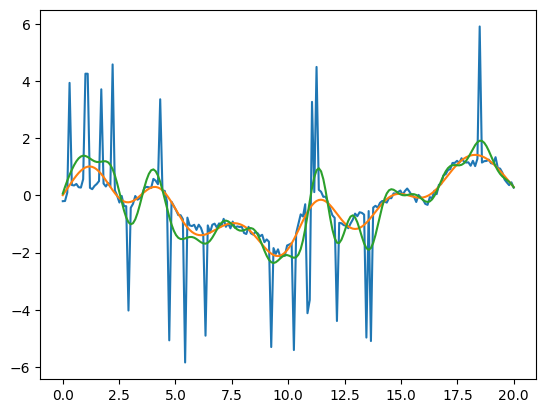

In [69]:
plt.plot(x,y)
pred=K@K_plus_W_inv@y
plt.plot(x,pred)
plt.plot(x,f_mean)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,4.5
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.9
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.01


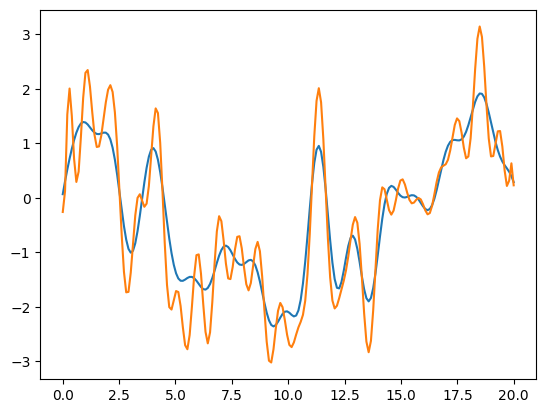

In [49]:
def maximize_c(y, quant):
            return np.quantile(abs(y), 1 - quant)
c=maximize_c(y-mean_loo,0.1)
W=1/(1+(tf.squeeze(y)-mean_loo)**2/c**2)
W=tf.linalg.tensor_diag(tf.reduce_mean(W)/W)*sigma**2

K_plus_W_inv=tf.linalg.inv(K+W)
marginal=tf.reduce_sum(-0.5 *tf.transpose(y)@K_plus_W_inv@y-tf.math.log(tf.linalg.det(K_plus_W_inv)))
W.shape

TensorShape([200, 200])

In [50]:
mean_loo

<tf.Tensor: shape=(200,), dtype=float64, numpy=
array([ 0.61103224,  1.19268849,  1.47892498, -0.44420556,  1.70063605,
        1.74455459,  1.79105702,  1.91528341,  2.0065121 ,  1.97939113,
        1.04692638,  1.01794301,  1.94114901,  1.82900681,  1.66978883,
        1.56042661,  1.51498841,  0.70374393,  1.70460036,  1.86597995,
        1.9342956 ,  1.96411319,  0.28824012,  1.53579097,  1.10080831,
        0.54894485, -0.14260599, -0.71343343, -1.24406557, -0.46522008,
       -1.76407339, -1.73319415, -1.52536828, -1.04146448, -0.50543169,
        0.04851751,  0.55398386,  1.00592172,  1.33891305,  1.50798395,
        1.41918457,  1.24572894,  0.93351728, -0.75909089, -0.01224676,
       -0.58406139, -1.11261561,  0.58915693, -2.1806299 , -2.56847935,
       -2.81812305, -2.8995095 , -2.88526571, -2.73007772, -0.40115165,
       -2.39951908, -2.1983211 , -2.09366645, -2.064119  , -2.04555794,
       -2.14736395, -2.20209   , -2.22384039, -0.98211646, -2.270654  ,
       -2.097625

In [52]:

W=1/(1+(tf.squeeze(y)-mean_loo)**2/c**2)
W=tf.linalg.tensor_diag(tf.reduce_mean(W)/W)
tf.linalg.diag_part(W)

<tf.Tensor: shape=(200,), dtype=float64, numpy=
array([0.9319256 , 1.0273308 , 1.02537535, 2.33039454, 1.01709714,
       1.02936282, 1.02796084, 1.08232734, 1.10863705, 1.0326352 ,
       1.65957798, 1.67277051, 1.09396526, 1.07787821, 1.01750335,
       0.98359475, 0.95969814, 1.5643601 , 1.00760801, 1.0642405 ,
       1.05273479, 1.09005771, 2.27253438, 1.02147058, 0.97497349,
       0.93016847, 0.88342591, 0.89115538, 0.93908543, 1.83768263,
       1.01647238, 1.0387996 , 1.0535766 , 0.9424576 , 0.89498551,
       0.88221948, 0.88879765, 0.91977913, 0.9660349 , 0.99926674,
       0.93557532, 0.922498  , 0.90425352, 2.16411499, 0.8847358 ,
       0.92396124, 0.94199586, 3.29586314, 1.17283467, 1.24901446,
       1.28260546, 1.2521158 , 1.24605961, 1.15561451, 3.1142179 ,
       1.08130871, 0.98264551, 0.96118524, 0.96376769, 0.93580654,
       0.97783786, 0.96816779, 0.93744676, 2.04220279, 0.9952121 ,
       0.93076196, 0.94674386, 0.9196933 , 0.88694042, 0.88368083,
       0.88562

In [15]:
kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
K = kernel.matrix(X, X)
K_plus_W_inv=tf.linalg.inv(K+W)
K_plus_W_inv_y=K_plus_W_inv@y
mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
sigma_loo=1/tf.linalg.diag_part(K_plus_W_inv)
"""vv = tfp.distributions.Normal(mean_loo, sigma_loo)
LOO_probs=vv.log_prob(tf.squeeze(y))
W=tf.linalg.tensor_diag(LOO_probs/sum(LOO_probs))*N/sigma**2
"""
W=tf.eye(N,N,dtype=tf.float64)*sigma**2
def maximize_c(y, quant):
            return np.quantile(abs(y), 1 - quant)
c=maximize_c(y-mean_loo,0.1)
#W=1/(1+(tf.squeeze(y)-mean_loo)**2/c**2)
#W=tf.linalg.tensor_diag(W/sum(W))*sigma**2/N

K_plus_W_inv=tf.linalg.inv(K+W)
marginal=tf.reduce_sum(-0.5 *tf.transpose(y)@K_plus_W_inv@y-tf.math.log(tf.linalg.det(K_plus_W_inv)))

<tf.Tensor: shape=(200, 200), dtype=float64, numpy=
array([[0.00792101, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00792101, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00792101, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00792101, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00792101,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00792101]])>